# Ground-truth comparison and ensemble sorting of a synthetic Neuropixels recording

This notebook reproduces figures 2 and 3 from the paper [**SpikeInterface, a unified framework for spike sorting**](https://www.biorxiv.org/content/10.1101/796599v2).

The data set for this notebook is available on the Dandi Archive: [https://gui.dandiarchive.org/#/dandiset/000034](https://gui.dandiarchive.org/#/dandiset/000034).

The entire data archive can be downloaded with the command `dandi download https://gui.dandiarchive.org/#/dandiset/000034/draft` (about 75GB).

The data file required to run the code is:
- the raw data: [sub-MEAREC-250neuron-Neuropixels_ecephys.nwb](https://girder.dandiarchive.org/api/v1/item/5f2c0e33ee8baa608594a16b/download)

This file should be in the same directory where the notebook is located (otherwise adjust paths below).

Author: [Matthias Hennig](http://homepages.inf.ed.ac.uk/mhennig/), University of Edinburgh, 22 Aug 2020

### Requirements

For this need you will need the following Python packages:

- numpy
- pandas
- matplotlib
- seaborn
- spikeinterface
- dandi
- matplotlib-venn

To run the MATLAB-based sorters, you would also need a MATLAB license.
For other sorters, please refer to the documentation on [how to install sorters](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html).

In [1]:
import os

import matplotlib
#matplotlib.use('Agg')

%load_ext autoreload
%autoreload 2

%matplotlib tk
%autosave 180
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Matlab sorter paths:
# change these to match your environment
# os.environ["IRONCLUST_PATH"] = "./ironclust"
# os.environ["KILOSORT2_PATH"] = "./Kilosort2"
# os.environ["HDSORT_PATH"] = "./HDsort"

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib_venn import venn3

import spikeinterface as si
import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw
from spikecomparison import GroundTruthStudy

#%matplotlib notebook

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
# print version information
si.print_spikeinterface_version()
ss.print_sorter_versions()

Autosaving every 180 seconds


spikeinterface: 0.12.0
  * spikeextractor: 0.9.6
  * spiketoolkit: 0.7.5
  * spikesorters: 0.4.4
  * spikecomparison: 0.3.2
  * spikewidgets: 0.5.3

yass: 2.0


# Set up ground truth study an run all sorters

In [2]:
study_path = Path('/media/cat/1TB/spikesorting/')
data_path = Path('.')

# 
study_folder = study_path / 'study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/'

# the original data
# this NWB file contains both the ground truth spikes and the raw data
#data_filename = data_path / 'sub-MEAREC-250neuron-Neuropixels_ecephys.nwb'
data_filename = '/media/cat/1TB/spikesorting/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb'
SX_gt = se.NwbSortingExtractor(str(data_filename))
RX = se.NwbRecordingExtractor(str(data_filename))

print (" checking that gt data is saved")
if not os.path.isdir(study_folder):
    gt_dict = {'rec0' : (RX, SX_gt) }
    study = GroundTruthStudy.create(study_folder, gt_dict)
else:
    study = GroundTruthStudy(study_folder)

sorter_list = ['herdingspikes', 'kilosort2', 'ironclust',
               'spykingcircus', 'tridesclous', 'hdsort', 'yass06', 'yass']
sorter_names = ['HerdingSpikes', 'Kilosort2', 'Ironclust',
                'SpykingCircus', 'Tridesclous', 'HDSort', 'YASS0.6', 'YASS']
sorter_names_short = ['HS', 'KS', 'IC', 'SC', 'TDC', 'HDS', 'YASS', 'YASS0.6']

 checking that gt data is saved


In [3]:
# Not needed because already computed
# study.run_sorters(sorter_list, mode='keep', engine='loop', verbose=True)

# study.copy_sortings()

# # compute or load SNR for the ground truth units
# snr_file = study_folder / 'snr.npy'
# if os.path.isfile(snr_file):
#     snr = np.load(snr_file)
# else:
#     print('computing snr')
#     # note this is quite slow for a NWB file as the data is arranged as channels:time
#     # it is faster to first write out a binary file in time:channels order
#     snr = st.validation.compute_snrs(SX_gt, RX, apply_filter=False, verbose=False, 
#                                      memmap=True, max_spikes_per_unit_for_snr=500)
#     np.save(snr_file, snr)

In [6]:
# sorting_outputs = []
# for sort_name in sorter_list:
#     sorting = study.get_sorting(sort_name)
#     sorting_outputs.append(sorting)
    
    

In [6]:
# sorting_ks2 = study.get_sorting("kilosort2")
# snr = st.validation.compute_snrs(sorting_ks2, RX, apply_filter=False, verbose=False, 
#                                  memmap=True, max_spikes_per_unit_for_snr=500, n_jobs=16, 
#                                  chunk_mb=4000)
# snr_bad = []
# for fp_unit in fp_units:
#     snr_bad.append(sorting_ks2.get_unit_property(10, "snr"))
    

# Run the ground truth comparison and summarise the results

In [7]:
study.run_comparisons(exhaustive_gt=True, 
                      match_score=0.0,
                      delta_time=3.0)

# 
comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

In [10]:
dataframes['count_units']

,rec_name,sorter_name,num_gt,num_sorter,num_well_detected,num_redundant,num_overmerged,num_false_positive,num_bad
0,rec0,tridesclous,250,189,136,0,5,0,0
1,rec0,spykingcircus,250,343,176,40,1,53,93
2,rec0,herdingspikes,250,233,127,0,4,0,0
3,rec0,ironclust,250,283,199,16,5,17,33
4,rec0,kilosort2,250,354,241,71,2,33,104
5,rec0,yass,250,261,246,0,1,11,11
6,rec0,hdsort,250,457,194,4,3,203,207
7,rec0,yass06,250,1095,115,191,3,654,845


In [11]:
######################################################
########### GET PTPS OF ALL SORTED UNITS #############
######################################################
# Get PTPS of each sorted unit
from tqdm import tqdm
from Ephys import Ephys
fname_binary = '/media/cat/1TB/spikesorting/sub-MEAREC-250neuron-Neuropixels_ecephys.bin'
n_channels = 384
n_times = 101
ephys = Ephys(fname_binary,
              n_channels,
              n_times)

# get ptps for all units
for sorter in sorter_list:
    root_dir = '/media/cat/1TB/spikesorting/study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/sortings/rec0[#]'
    fname = root_dir + sorter + '.npz'

    fname_out = fname[:-4]+"_ptps.npy"
    if os.path.exists(fname_out):
        continue
    print (fname)
        
    data = np.load(fname)
    # get units
    spike_ids = data['spike_labels']
    spike_times = data['spike_indexes']
    
    ptps = []
    for unit_id in tqdm(np.unique(spike_ids)):
        idx = np.where(spike_ids==unit_id)[0]
        spikes = np.int32(spike_times[idx])
        ephys.get_ptp(spikes)
        ptps.append(ephys.ptp)
    
    np.save(fname_out, ptps)


  0%|          | 0/1095 [00:00<?, ?it/s]

/media/cat/1TB/spikesorting/study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/sortings/rec0[#]yass06.npz


100%|██████████| 1095/1095 [02:02<00:00,  8.92it/s]


In [17]:
######################################################
############## GET RESULST OF MATCHING ###############
######################################################
# Select sort result and get IDS of cells:
# sorter_list = ['herdingspikes', 'kilosort2', 'ironclust',
#                'spykingcircus', 'tridesclous', 'hdsort', 'yass']

#
def fix_ids(rr, spike_ids, ids_seq):
        
    r2 = []
    for k in range(len(rr)):
        idx = np.where(spike_ids==rr[k])[0]
        r2.append(ids_seq[idx])

    return np.array(r2).squeeze()

    
for ctr, sorter in enumerate(sorter_list):
    ax=plt.subplot(2,4,ctr+1)
    print (sorter)
    sorter_comp = comparisons[('rec0', sorter)]
    y1 = sorter_comp.agreement_scores.max()

    # 
    r1 = sorter_comp.get_redundant_units()
    w1 = sorter_comp.get_well_detected_units()
    b1 = sorter_comp.get_bad_units()


    ptps = np.load(root_dir + sorter +"_ptps.npy")
    
    # adjust ids in case non-sequential unit ids
    data = np.load(root_dir + sorter + '.npz')
    spike_ids = np.unique(data['spike_labels'])
    ids_seq = np.arange(spike_ids.shape[0])

    r1 = fix_ids(r1, spike_ids, ids_seq)
    w1 = fix_ids(w1, spike_ids, ids_seq)
    b1 = fix_ids(b1, spike_ids, ids_seq)
    
    try: 
        if w1.shape[0]>0:
            plt.scatter(ptps[w1],y1[w1], c='blue')

        if b1.shape[0]>0:
            plt.scatter(ptps[b1],y1[b1], c='red')

        if r1.shape[0]>0:
            plt.scatter(ptps[r1],y1[r1], c='green')

    except:
        y1 = sorter_comp.agreement_scores.max().to_numpy()
        if w1.shape[0]>0:
            plt.scatter(ptps[w1],y1[w1], c='blue')

        if b1.shape[0]>0:
            plt.scatter(ptps[b1],y1[b1], c='red')

        if r1.shape[0]>0:
            plt.scatter(ptps[r1],y1[r1], c='green')
            
    plt.title(sorter,fontsize=20)
    plt.ylim(0,1)
plt.suptitle('study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/')
plt.show()

herdingspikes
kilosort2
ironclust
spykingcircus
tridesclous
hdsort
yass06
yass


In [16]:
##############################################################
################# PLOT BAD VS. GOOD ##########################
##############################################################

entries = ['num_well_detected','num_redundant','num_ovemerged','num_false_positive','num_bad']
clrs = ['brown','magenta','cyan','green','blue','red','pink', 'grey']
names = dataframes['count_units']['sorter_name']

# 
well_detected = dataframes['count_units']['num_well_detected']
print (well_detected)

# 
bad_units = dataframes['count_units']['num_bad']

size = 100
# 
fig=plt.figure()
ax=plt.subplot(211)
dists = []
for k in range(len(bad_units)):
    print (k)
    plt.scatter(bad_units[k], well_detected[k],
                s=size,
               c=clrs[k], label = names[k])

    dists.append(np.linalg.norm(np.array([0,250])-np.array([bad_units[k],well_detected[k]]))/250.)

    
plt.plot([0,bad_units[3]],[250,well_detected[3]],'r--',c='black')

#
plt.scatter(0,250,s=size*2, c='black', label="Perfect Sort")

#
plt.xlim(0,275)
plt.ylim(0,275)
plt.xlabel("# bad units sorted")
plt.ylabel("# good units sorted")

plt.legend(ncol=2)


# plot unit space values
ax=plt.subplot(212)
for k in range(len(bad_units)):
    plt.scatter(k, dists[k], 
                s=size,
                c=clrs[k])

plt.xticks(np.arange(8), names)
plt.ylabel("Normalized sorting distance to Perfect Sort")
plt.suptitle("")
plt.show()


0    136
1    176
2    127
3    199
4    241
5    246
6    194
7    115
Name: num_well_detected, dtype: object
0
1
2
3
4
5
6
7


In [166]:
rec=study.get_recording()


In [168]:
template = st.postprocessing.get_unit_templates(rec, yass_s, unit_ids=b1)

In [171]:
t = np.array(template)
print (t.shape)
print (b1)

(19, 384, 192)
[30, 36, 45, 48, 59, 67, 87, 107, 109, 114, 151, 158, 170, 176, 183, 198, 221, 236, 258]


In [174]:
plt.plot(t[3].T, c='black')
plt.show()


In [175]:
y1.iloc[48]

0.0040032754071513054

In [8]:
plt.scatter(ptps_yass,
            yass_comp.agreement_scores.max())
plt.show()


NameError: name 'ptps_yass' is not defined

In [34]:
print (b1)
print (np.array(ptps_yass)[b1])

[30, 36, 45, 48, 59, 67, 87, 107, 109, 114, 151, 158, 170, 176, 183, 198, 221, 236, 258]
[138.19919   52.359978 158.42441  328.93988  158.14108   40.856567
  95.52229   74.14123   99.50074  111.4209    69.25274   38.560463
  61.3503   280.048     63.120834 179.92615   98.60075   35.029198
  42.72722 ]


In [11]:
yass_s = study.get_sorting('yass')


In [13]:
gt = study.get_ground_truth()

In [18]:
gt_spikes = gt.get_units_spike_train()

In [51]:
#for b in b1:
for b in [221]:
    matches = ephys.match_unit_to_gt(yass_s.get_unit_spike_train(b),
                      gt.get_units_spike_train())

    print ("bad unit: ", b, " ptp: ", ptps_yass[b], " # of spikes in sorted unit: ", 
           yass_s.get_unit_spike_train(b).shape,
          " best match from gt: ", np.max(matches))


100%|██████████| 250/250 [00:00<00:00, 484.87it/s]

bad unit:  221  ptp:  98.60075  # of spikes in sorted unit:  (234,)  best match from gt:  99


# of spikes in sorted unit:  (124,)
7


In [12]:
len(yass_s.get_unit_spike_train(48))

2404

In [9]:
# comparison summary
dataframes['count_units']



,rec_name,sorter_name,num_gt,num_sorter,num_well_detected,num_redundant,num_overmerged,num_false_positive,num_bad
0,rec0,tridesclous,250,189,136,0,5,0,0
1,rec0,spykingcircus,250,343,176,40,1,53,93
2,rec0,herdingspikes,250,233,129,0,4,0,0
3,rec0,ironclust,250,283,202,17,5,16,33
4,rec0,kilosort2,250,415,245,98,2,67,165
5,rec0,yass,250,261,246,0,1,11,11
6,rec0,hdsort,250,457,196,6,3,201,207


In [98]:
##############################################################
################# PLOT BAD VS. GOOD ##########################
##############################################################

entries = ['num_well_detected','num_redundant','num_ovemerged','num_false_positive','num_bad']
clrs = ['brown','magenta','cyan','green','blue','red','pink']
names = dataframes['count_units']['sorter_name']

# 
well_detected = dataframes['count_units']['num_well_detected']
#print (well_detected)

# 
bad_units = dataframes['count_units']['num_bad']

size = 100
# 
fig=plt.figure()
ax=plt.subplot(211)
dists = []
for k in range(len(bad_units)):
    plt.scatter(bad_units[k], well_detected[k],
                s=size,
               c=clrs[k], label = names[k])

    dists.append(np.linalg.norm(np.array([0,250])-np.array([bad_units[k],well_detected[k]]))/250.)

    
plt.plot([0,bad_units[3]],[250,well_detected[3]],'r--',c='black')

#
plt.scatter(0,250,s=size*2, c='black', label="Perfect Sort")

#
plt.xlim(0,275)
plt.ylim(0,275)
plt.xlabel("# bad units sorted")
plt.ylabel("# good units sorted")

plt.legend(ncol=2)


# plot unit space values
ax=plt.subplot(212)
for k in range(len(bad_units)):
    plt.scatter(k, dists[k], 
                s=size,
                c=clrs[k])

plt.xticks(np.arange(8), names)
plt.ylabel("Normalized sorting distance to Perfect Sort")
plt.suptitle("")
plt.show()



In [23]:
# data = RX.get_traces()
# print (data.shape)
# print (type(data[0][0]))
# np.save('/media/cat/1TB/spikesorting/sub-MEAREC-250neuron-Neuropixels_ecephys.npy',data)

# data.tofile('/media/cat/1TB/spikesorting/sub-MEAREC-250neuron-Neuropixels_ecephys.bin')


In [21]:
# # 
# from Ephys import Ephys
# fname_binary = '/media/cat/1TB/spikesorting/sub-MEAREC-250neuron-Neuropixels_ecephys.bin'
# n_channels = 384
# n_times = 101
# ephys = Ephys(fname_binary,
#               n_channels,
#               n_times)
# # 


In [99]:
print (dataframes['perf_by_units'].iloc[0])

rec_name                       rec0
sorter_name             tridesclous
gt_unit_id                        0
accuracy                   0.725212
recall                     0.774584
precision                   0.91921
false_discovery_rate      0.0807899
miss_rate                  0.225416
Name: 0, dtype: object


In [100]:
# regenerate scatter plots
# seems not all sorted units are there;
sorter_names = dataframes['perf_by_units']['sorter_name']

ctr=1
for sorter in sorter_list:
    idxs = np.where(sorter_names==sorter)[0]

    accuracy = []
    snr = []
    for idx in idxs:
        accuracy.append(dataframes['perf_by_units'].iloc[idx]['accuracy'])
        snr.append(dataframes['perf_by_units'].iloc[idx]['snr'])

    ax=plt.subplot(2,4,ctr)
    print ("sorter: ", sorter, " idx: ", idxs.shape)
    plt.scatter(snr, accuracy)
    plt.title(sorter)
    ctr+=1
    
plt.show()

KeyError: 'snr'

In [127]:
 dataframes['perf_by_units']

dict_keys(['run_times', 'perf_by_units', 'count_units'])

In [6]:
yass06 = np.load('/media/cat/1TB/spikesorting/study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/spike_train_eLife_Yass06.npy')
print (yass06.shape)

data = np.load('/media/cat/1TB/spikesorting/study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/sortings/rec0[#]yass.npz')
sampling_frequency = data['sampling_frequency']
spike_labels = yass06[:,1]
spike_indexes = yass06[:,0]
unit_ids = np.unique(spike_labels)
print (unit_ids)

np.savez('/media/cat/1TB/spikesorting/study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/sortings/rec0[#]yass06.npz',
        sampling_frequency = sampling_frequency,
         spike_labels = spike_labels,
         spike_indexes = spike_indexes,
         unit_ids = unit_ids
        )


(1336063, 2)
[   0    1    2 ... 1092 1093 1094]


# Figure 1 - ground truth study results

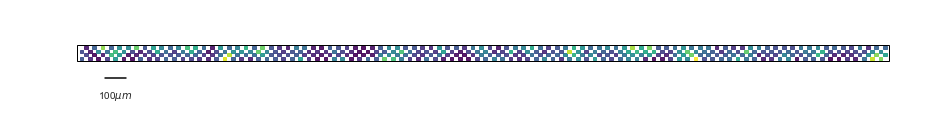

In [5]:
# activity levels on the probe

plt.figure(figsize=(16,2))
ax = plt.subplot(111)
w = sw.plot_activity_map(RX, trange=(0,20), transpose=True, ax=ax, background='w', frame=True)
ax.plot((-1800,-1700), (-120,-120), 'k-')
ax.annotate('100$\\mu m$',(-1750,-220), ha='center');


(-750, 4435.259765625)

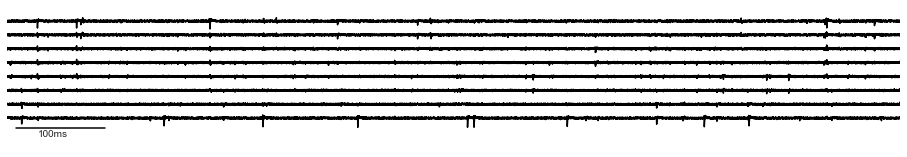

In [6]:
# example data traces

plt.figure(figsize=(16,6))
ax = plt.subplot(111)
w = sw.plot_timeseries(RX, channel_ids=range(10,18), color='k', ax=ax, trange=(1,2))
ax.axis('off')
p = ax.get_position()
p.y0 = 0.58
ax.set_position(p)
ax.set_xticks(())
ax.plot((1.01,1.11),(-400,-400),'k-')
ax.annotate('100ms',(1.051,-750), ha='center');
ax.set_ylim((-750,ax.set_ylim()[1]))

In [11]:
plt.figure()
ax = plt.subplot(111)
n = []
for s in sorter_list:
    n.append(len(study.get_sorting(s).get_unit_ids()))
ax.bar(range(len(sorter_list)), n, color='tab:blue')
ax.set_xticks(range(len(sorter_names_short)))
ax.set_xticklabels(sorter_names_short, rotation=60, ha='center')
ax.set_ylabel('Units detected') 
ax.axhline(250, ls='--', color="grey")
clear_axes(ax)

In [12]:
plt.figure()
ax = plt.subplot(111)
p = ax.get_position()
p.x1=0.85
ax.set_position(p)
sns.set_palette(sns.color_palette("Set1"))
df = pd.melt(dataframes['perf_by_units'], id_vars='sorter_name', var_name='Metric', value_name='Score', 
        value_vars=('accuracy','precision', 'recall'))
sns.swarmplot(data=df, x='sorter_name', y='Score', hue='Metric', dodge=True,
                order=sorter_list,  s=3, ax=ax)
ax.set_xticklabels(sorter_names_short, rotation=30, ha='center')
ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., frameon=False, fontsize=8, markerscale=0.5)
ax.set_xlabel(None);
ax.set_ylabel('Score');
clear_axes(ax)

In [22]:
#######################################
########  BAR PLOTS 
####################################
plt.figure()
ax = plt.subplot(111)
p = ax.get_position()
p.x1=0.85
ax.set_position(p)
df = pd.melt(dataframes['count_units'], id_vars='sorter_name', var_name='Type', value_name='Units', 
        value_vars=('num_well_detected', 'num_false_positive', 'num_redundant', 'num_overmerged'))
sns.set_palette(sns.color_palette("Set1"))
sns.barplot(x='sorter_name', y='Units', hue='Type', data=df,
                order=sorter_list, ax=ax)
ax.set_xticklabels(sorter_names_short, rotation=30, ha='right')
ax.axhline(250, ls='--', color="grey")
ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., frameon=False, fontsize=8, markerscale=0.1)
for t, l in zip(ax.legend_.texts, ("Well detected", "False positive", "Redundant", "Overmerged")): t.set_text(l)
ax.set_xlabel(None);
clear_axes(ax)



In [21]:
# precision vs. recall and accuracy vs. SNR
fig = plt.figure(figsize=(14, 4))

sns.set_palette(sns.color_palette("deep"))

axesA = []
for i,s in enumerate(sorter_list):
    ax = plt.subplot(2,len(sorter_list),i+1)
    axesA.append(ax)

    g = sns.scatterplot(data=dataframes['perf_by_units'].loc[dataframes['perf_by_units'].sorter_name==s], 
                    x='precision', y='recall', s=30, edgecolor=None, alpha=0.1)
    ax.set_title(sorter_names[i])
    ax.set_aspect('equal')
    clear_axes(ax)
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')

for ax in axesA[1:]:
    axesA[0].get_shared_y_axes().join(axesA[0], ax)
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.autoscale()
    
############### B

df = dataframes['perf_by_units']

# add snr to the by-unit table
if 'snr' not in df.keys():
    snr_d = {k:snr[k] for i,k in enumerate(SX_gt.get_unit_ids())}
    df['snr'] = df['gt_unit_id'].map(snr_d)
    
# 
axesB = []
for i,s in enumerate(sorter_list):
    ax = plt.subplot(2,len(sorter_list),len(sorter_list)+i+1)
    axesB.append(ax)
    
    g = sns.scatterplot(data=dataframes['perf_by_units'].loc[dataframes['perf_by_units'].sorter_name==s], 
                        x='snr', y='accuracy', s=30, alpha=0.2)
    clear_axes(ax)
    ax.set_xlabel('Ground truth SNR')
    ax.set_ylabel('Accuracy')
    
for ax in axesB[1:]:
    axesB[0].get_shared_y_axes().join(axesB[0], ax)
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.autoscale()
    

IndexError: list index out of range

## Extract False positives

In [39]:
comparisons = study.comparisons

/Users/abuccino/anaconda3/envs/si/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
yass_comp = comparisons[('rec0', 'yass')]

In [44]:
fp_units = yass_comp.get_false_positive_units()
overmerged_units = yass_comp.get_overmerged_units()
redundant_units = yass_comp.get_redundant_units()

/Users/abuccino/anaconda3/envs/si/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Figure 3 - comparison of sorter outputs and ensembe sorting

In [11]:
# perform an all-to-all multicomparison or load it from
# disk if file exists

sortings = []
for s in sorter_list:
    sortings.append(study.get_sorting(s))

cmp_folder = study_folder / 'multicomparison/'
if not os.path.isdir(cmp_folder):
    os.mkdir(cmp_folder)
if not os.path.isfile(cmp_folder / 'multicomparison.gpickle'):
    mcmp = sc.compare_multiple_sorters(sorting_list=sortings, name_list=sorter_names_short, 
                                   verbose=False, match_score=0.5)
    print('saving multicomparison')
    mcmp.dump(cmp_folder)
else:
    print('loading multicomparison')
    mcmp = sc.MultiSortingComparison.load_multicomparison(cmp_folder)
    
mcmp_graph = mcmp.graph.copy()


loading multicomparison


In [12]:
# get sorting extractors with unit with no agreement (minimum agreement = 1) and one
# with at least 2 sorters in agreement
not_in_agreement = mcmp.get_agreement_sorting(minimum_agreement_count=1, minimum_agreement_count_only=True)
in_agreement = mcmp.get_agreement_sorting(minimum_agreement_count=2)

# score these against ground truth
cmp_no_agr = sc.compare_sorter_to_ground_truth(SX_gt, not_in_agreement)
cmp_agr = sc.compare_sorter_to_ground_truth(SX_gt, in_agreement)

# now collect results for each sorter:

# create dict to collect results
results = {'TP':{}, 'FP':{}, 'SNR':{}}
ns = len(sorter_names_short)
for s in sorter_names_short:
    results['TP'][s] = dict(zip(range(1,ns+1), [0]*(ns+1)))
    results['FP'][s] = dict(zip(range(1,ns+1), [0]*(ns+1)))
    results['SNR'][s] = dict(zip(range(1,ns+1), [[]]*(ns+1)))
    
# sorter names
dict_names = dict(zip(sorter_names_short, sorter_list))

# iterate over all units gathered from subgraphs
for u in  mcmp._new_units.keys():
    found_in_gt = []
    gt_index = []
    # check if units have a match in ground truth, store boolen
    for u2 in mcmp._new_units[u]['sorter_unit_ids'].items():
        found_in_gt.append(u2[1] in study.comparisons['rec0',dict_names[u2[0]]].best_match_12.values)
        if found_in_gt[-1]:
            gt_index.append(np.where(study.comparisons['rec0',dict_names[u2[0]]].best_match_12==u2[1])[0][0])
    if len(set(gt_index))>1:
        print('different gt units: ',u, gt_index)
    if np.sum(found_in_gt)==len(found_in_gt):
#     if np.sum(found_in_gt)>0:#==len(found_in_gt):  # use this if interested in equal matches
        key = 'TP'
    else:
        key = 'FP'
        if len(found_in_gt)>1:
            print('FP unit found by >1 sorter: ',u)
        
    for i,u2 in enumerate(mcmp._new_units[u]['sorter_unit_ids'].items()):
#         results[key][u2[0]][np.sum(found_in_gt)] += 1 # use this if interested in equal matches
        results[key][u2[0]][len(found_in_gt)] += 1
        if key is 'TP':
            # something odd with nested oython dicts requires this:
            d = results['SNR'][u2[0]][len(found_in_gt)].copy()
            d.append(snr[gt_index[i]])
            results['SNR'][u2[0]][len(found_in_gt)] = d
            # this fails, I wonder why:
            # results['SNR'][u2[0]][len(found_in_gt)].append(snr[gt_index[i]])


different gt units:  20 [213, 213, 213, 146, 213, 213]
different gt units:  35 [189, 189, 185, 189, 189]
different gt units:  42 [224, 224, 224, 76, 224, 224]
different gt units:  46 [108, 108, 108, 90, 108, 108]
FP unit found by >1 sorter:  92
different gt units:  102 [153, 197, 197, 197, 197, 197]
different gt units:  103 [175, 175, 175, 11, 175, 175]
FP unit found by >1 sorter:  111
different gt units:  114 [157, 157, 107, 157, 157, 157]
different gt units:  149 [78, 99, 99, 99, 99]
FP unit found by >1 sorter:  150
FP unit found by >1 sorter:  158
different gt units:  162 [179, 196, 196, 196, 196, 196]
different gt units:  284 [185, 185, 185, 177, 185]
different gt units:  316 [90, 90, 90, 57, 90]
FP unit found by >1 sorter:  418
FP unit found by >1 sorter:  549
different gt units:  673 [129, 182]


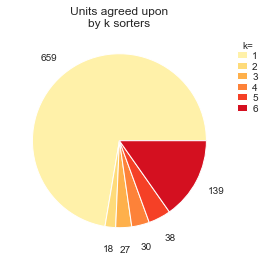

In [13]:
w = sw.plot_multicomp_agreement(mcmp, plot_type='pie')


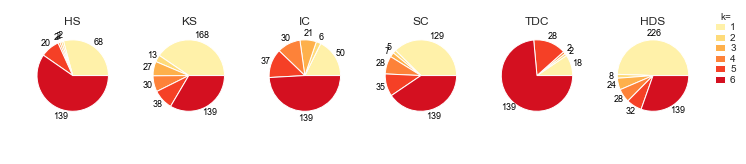

In [14]:
w = sw.plot_multicomp_agreement_by_sorter(mcmp, show_legend=True)


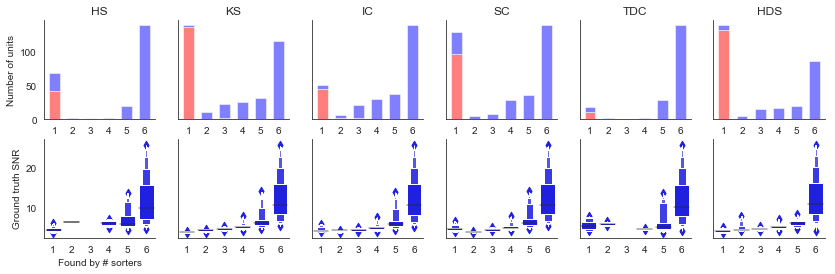

In [15]:
fig = plt.figure(figsize=(14,4))

axes = []
for i,s in enumerate(results['TP'].keys()):
    ax = plt.subplot(2,len(sorter_list), i+1)
    ax.bar(results['FP'][s].keys(), list(results['FP'][s].values()), alpha=0.5, width = 0.6, color='r', label='false positive')
    ax.bar(results['TP'][s].keys(), list(results['TP'][s].values()), bottom=list(results['FP'][s].values()), alpha=0.5, width = 0.6, color='b', label='matched')
    ax.set_xticks(range(1,len(sorter_list)+1))
    ax.set_xticklabels(range(1,len(sorter_list)+1))
    ax.set_title(s)
    clear_axes(ax)
    axes.append(ax)
    if i == 0:
        ax.set_ylabel('Number of units')
    else:
        ax.get_shared_y_axes().join(axes[0], ax)
        ax.set_yticklabels([])
    
    ax = plt.subplot(2,len(sorter_list), len(sorter_list)+i+1)
    d  = results['SNR'][s]
    sns.boxenplot(data=pd.DataFrame([pd.Series(d[k]) for k in d.keys()]).T, color='b', ax=ax)
    ax.set_xticks(range(0,len(sorter_list)))
    ax.set_xticklabels(range(1,len(sorter_list)+1))
    clear_axes(ax)
    axes.append(ax)
    if i == 0:
        ax.set_ylabel('Ground truth SNR')
        ax.set_xlabel('Found by # sorters')
    else:
        ax.get_shared_y_axes().join(axes[1], ax)
        ax.set_yticklabels([])
    

In [16]:
# numbers for figure above

sg_names, sg_units = mcmp.compute_subgraphs()
v, c = np.unique([len(np.unique(s)) for s in sg_names], return_counts=True)
df = pd.DataFrame(np.vstack((v,c,np.round(100*c/np.sum(c),2))).T,
             columns=('in # sorters','# units','percentage'))
print('all sorters, all units:')
print(df)
df = pd.DataFrame()
for i, name in enumerate(sorter_names_short):
    v, c = np.unique([len(np.unique(sn)) for sn in sg_names if name in sn], return_counts=True)
    cl = np.zeros(len(sorter_list), dtype=int)
    cl[v.astype(int)-1] = c
    df.insert(2*i,name,cl)
    df.insert(2*i+1,name+'%',np.round(100*cl/np.sum(cl),1))
print('\nper sorter:')
print(df)

for i,s in enumerate(results['TP'].keys()):
    print(s, list(results['FP'][s].values()))

all sorters, all units:
   in # sorters  # units  percentage
0           1.0    659.0       72.34
1           2.0     18.0        1.98
2           3.0     27.0        2.96
3           4.0     30.0        3.29
4           5.0     38.0        4.17
5           6.0    139.0       15.26

per sorter:
    HS   HS%   KS   KS%   IC   IC%   SC   SC%  TDC  TDC%  HDS  HDS%
0   68  29.2  168  40.5   50  17.7  129  37.6   18   9.5  226  49.5
1    2   0.9   13   3.1    6   2.1    5   1.5    2   1.1    8   1.8
2    2   0.9   27   6.5   21   7.4    7   2.0    0   0.0   24   5.3
3    2   0.9   30   7.2   30  10.6   28   8.2    2   1.1   28   6.1
4   20   8.6   38   9.2   37  13.1   35  10.2   28  14.8   32   7.0
5  139  59.7  139  33.5  139  49.1  139  40.5  139  73.5  139  30.4
HS [42, 1, 2, 0, 1, 0]
KS [164, 1, 2, 0, 1, 0]
IC [45, 2, 2, 0, 0, 0]
SC [97, 1, 0, 0, 1, 0]
TDC [11, 0, 0, 0, 1, 0]
HDS [214, 1, 0, 0, 1, 0]
